In [3]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random

In [4]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
seq_len = 200
num_epochs = 5000
lr = 0.001
num_outputs = 3
batch_size = 300
in_features = 2
noise = False
warm_up_epochs = 5
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
#criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=num_outputs,ys=y))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000


C:\Users\prajb\anaconda3new\envs\cuda_test\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


total params:2110979


In [5]:
%matplotlib inline
trains= main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size, seq_len, in_features, num_classes=num_outputs)

| epoch   0 | lr 0.0002 || loss 1.042
| epoch  50 | lr 0.0009997907554579108 || loss 0.218
| epoch 100 | lr 0.0009990888722130151 || loss 0.202
| epoch 150 | lr 0.0009978934620277638 || loss 0.143
| epoch 200 | lr 0.0009962057069904861 || loss 0.224
| epoch 250 | lr 0.0009940272760475888 || loss 0.233
| epoch 300 | lr 0.0009913603233532068 || loss 0.166
| epoch 350 | lr 0.0009882074861390568 || loss 0.169
| epoch 400 | lr 0.0009845718821065957 || loss 0.156
| epoch 450 | lr 0.0009804571063440617 || loss 0.182
| epoch 500 | lr 0.0009758672277714517 || loss 0.165
| epoch 550 | lr 0.0009708067851169456 || loss 0.153
| epoch 600 | lr 0.0009652807824287581 || loss 0.163
| epoch 650 | lr 0.0009592946841268572 || loss 0.122
| epoch 700 | lr 0.0009528544095994407 || loss 0.116
| epoch 750 | lr 0.0009459663273495134 || loss 0.131
| epoch 800 | lr 0.0009386372486973571 || loss 0.138
| epoch 850 | lr 0.0009308744210451167 || loss 0.168
| epoch 900 | lr 0.0009226855207101634 || loss 0.143
| epoch 

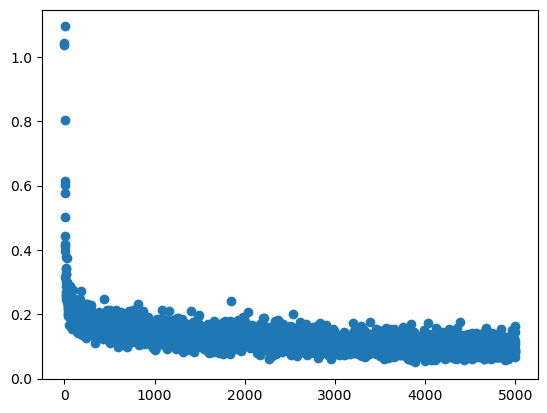

In [6]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

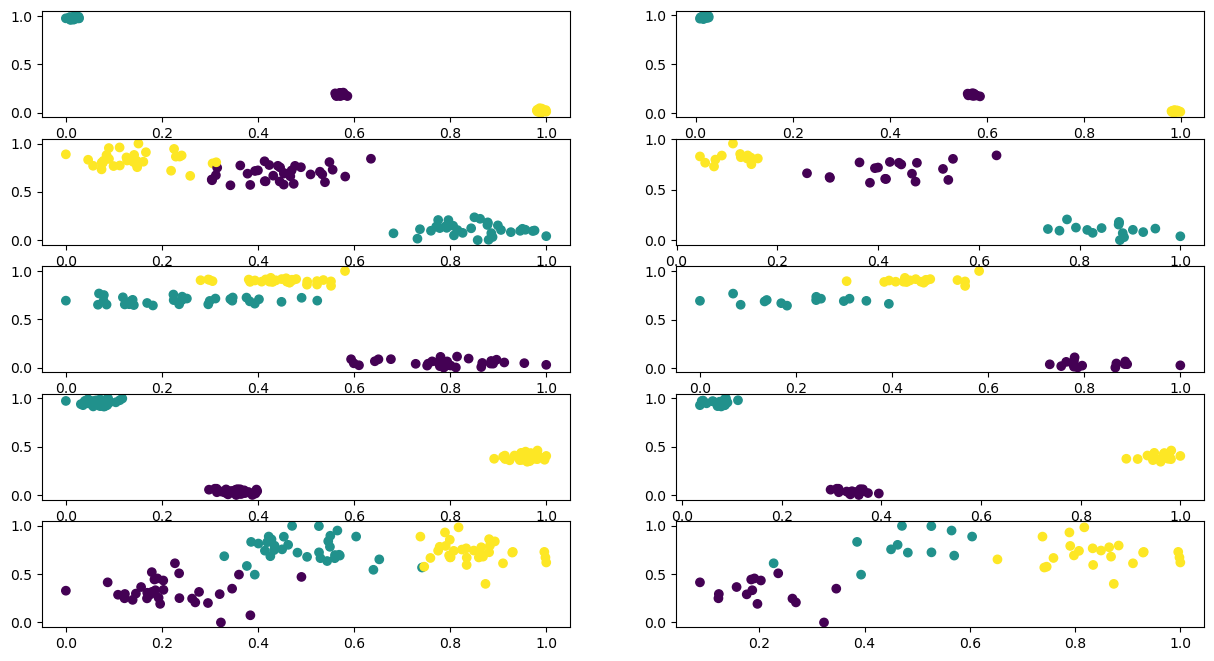

In [109]:
%matplotlib inline
temp_batch_size = 5
train_X, train_Y, y_target= prior.sample_clusters(batch_size=temp_batch_size,seq_len=100)
model.eval()
num_points = 50
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index]
    train_y = train_Y[:, batch_index] 
    axes[2 * batch_index].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits = model(train_x, num_points)
    predictions = torch.argmax(logits, dim=1)
    axes[2 * batch_index +1].scatter(train_X[num_points:,batch_index,0].cpu().numpy() , train_X[num_points:, batch_index, 1].cpu().numpy() , c=predictions.cpu().numpy())
    
plt.show()



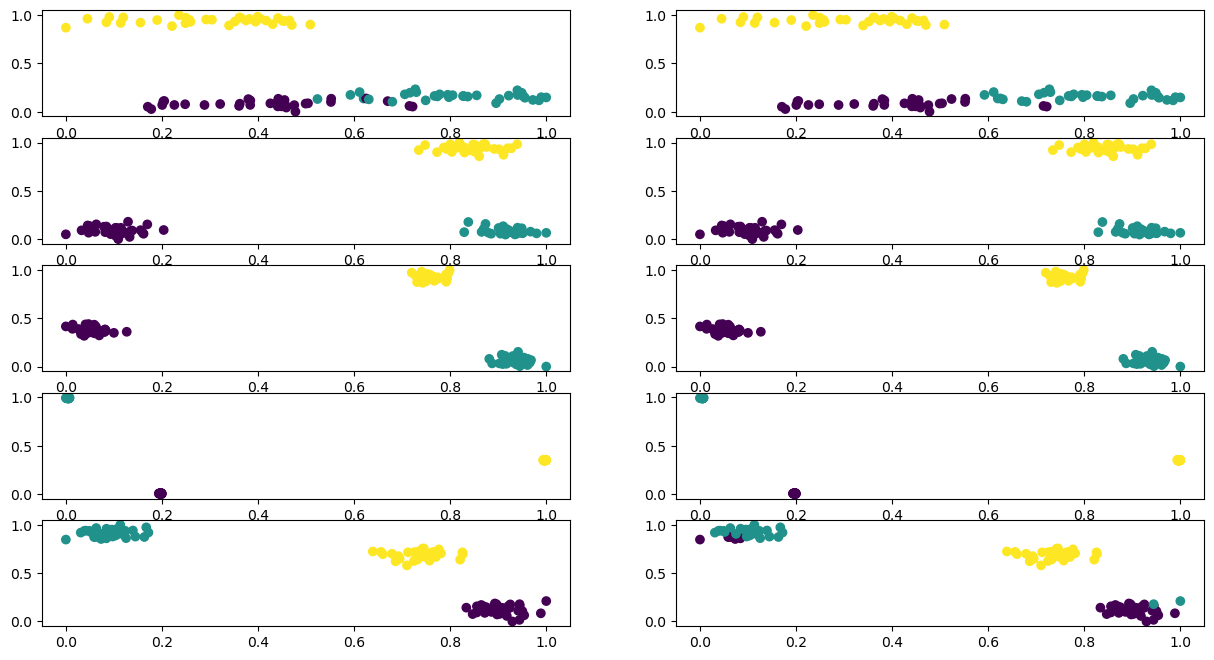

In [115]:
%matplotlib inline
temp_batch_size = 5
seq_len = 100
train_X, train_Y, y_target= prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len)
model.eval()
num_points = seq_len
X_total = torch.cat((train_X, train_X), dim=0) 
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index]
    train_y = train_Y[:, batch_index] 
    axes[2 * batch_index].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits = model(X_total[:, batch_index], num_points)
    # print(logits.shape)
    # print(len(predictions))
    predictions = torch.argmax(logits, dim=1)
    axes[2 * batch_index +1].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=predictions.cpu().numpy())
    
plt.show()



Sorted labels: [94 61 44  8 24  4 99 69 50  9]


In [ ]:
import itertools

def generate_swapped_permutations(arr):
    # Generate all possible swap pairs from the unique integers in the array
    swap_pairs = list(itertools.combinations(set(arr), 2))

    # Store the permutations
    permutations = set()

    # Iterate through all swap pairs
    for swap_pair in swap_pairs:
        swapped_arr = arr[:]
        # Perform the swap for the entire array
        for i in range(len(swapped_arr)):
            if swapped_arr[i] == swap_pair[0]:
                swapped_arr[i] = swap_pair[1]
            elif swapped_arr[i] == swap_pair[1]:
                swapped_arr[i] = swap_pair[0]
        # Add the swapped array to the set of permutations
        permutations.add(tuple(swapped_arr))

    return [list(p) for p in permutations]

# Example usage with the integers 1, 2, 3
arr = [1, 2, 3]
swapped_permutations = generate_swapped_permutations(arr)
for perm in swapped_permutations:
    print(perm)


In [204]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons, make_circles
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
import torch
import random
device = torch.device("cuda")


def sample_clusters(batch_size=100, seq_len=100, num_features=2, type_='make_blobs', noise=False):
    clusters_x = np.zeros((batch_size, seq_len,num_features))
    clusters_y = np.zeros((batch_size, seq_len))
    clusters_y_noisy = []
    for i in range(batch_size):
        std = random.random()
        centers = random.randint(2, 5)
        centers = 2
        x, y = make_blobs(n_samples=seq_len, n_features=num_features, centers=centers, cluster_std=std,
                          shuffle=True)
        x = preprocessing.MinMaxScaler().fit_transform(x)
        x, y = sort(x, y,centers)
        #x = preprocessing.MinMaxScaler().fit_transform(x)
        clusters_x[i] = x 
        clusters_y[i] = y 
        
        if noise:
            # todo add noise to the target
            pass
        else:
            clusters_y_noisy.append(y)

    clusters_x = torch.tensor(clusters_x, dtype=torch.float32)
    clusters_y = torch.tensor(clusters_y , dtype=torch.float32)
    clusters_x = clusters_x.permute(1, 0, 2)
    clusters_y = clusters_y.permute(1, 0)

    return clusters_x.to(device), clusters_y.to(device), clusters_y.to(device)


def sort(x, y, centers):
    distances = np.linalg.norm(x, axis=1)
    sorted_indices = np.argsort(distances)
    sorted_x = x[sorted_indices]
    sorted_y = y[sorted_indices]

    mapping = {}
    storage = set()
    curr = 0
    for i in range(len(sorted_y)):
        if len(mapping) == centers:
            break
        if sorted_y[i] not in storage:
            mapping[sorted_y[i]] = curr
            storage.add(sorted_y[i])
            curr += 1

    y_mapped = np.array([mapping[number] for number in sorted_y])
    indices = np.random.permutation(len(sorted_x))
    shuffled_x = sorted_x[indices]
    shuffled_y = y_mapped[indices]
    return sorted_x, y_mapped



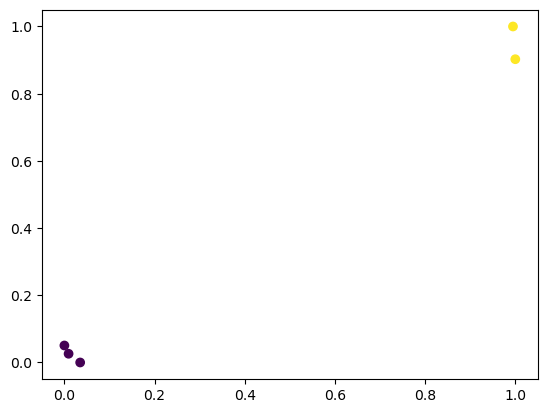

In [205]:
train_X, train_Y, y_target= sample_clusters(batch_size=1,num_features = 2, seq_len=5)

plt.scatter(train_X[:,0,0].cpu().numpy(), train_X[:,0,1].cpu().numpy() , c=train_Y[:,0].cpu().numpy())
plt.show()

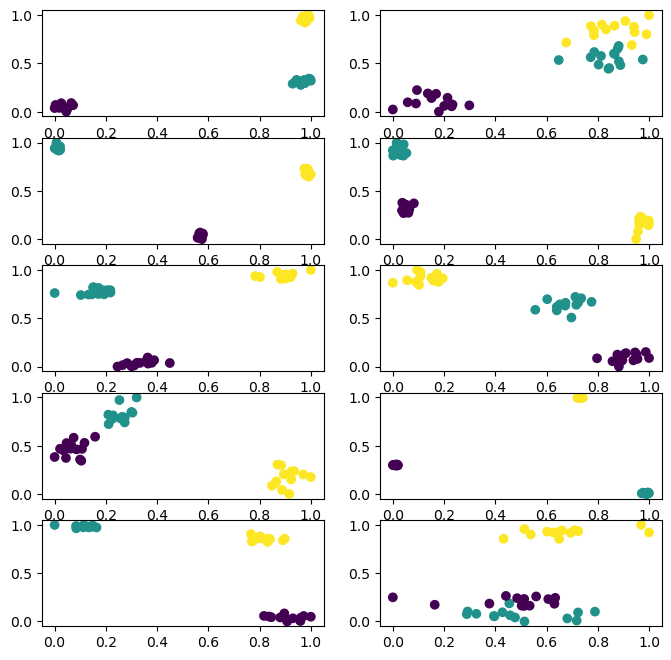

In [219]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, y_target= prior.sample_clusters(batch_size=temp_batch_size,seq_len=40)
model.eval()
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(8, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    axes[batch_index].scatter(train_X[:,batch_index,0].cpu().numpy() , train_X[:, batch_index, 1].cpu().numpy() , c=train_Y[:,batch_index].cpu().numpy())
    
plt.show()



In [ ]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, y_target= sample_clusters(batch_size=temp_batch_size,seq_len=100)
model.eval()
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    axes[batch_index].scatter(train_X[:,batch_index,0].cpu().numpy() , train_X[:, batch_index, 1].cpu().numpy() , c=train_Y[:,batch_index].cpu().numpy())
    
plt.show()



In [10]:
import itertools

def permute(num_classes):

    # Given integers
    numbers = np.arange(num_classes)

    # Generate all permutations of size 3
    permutation = list(itertools.permutations(numbers, num_classes))

    return permutation

In [15]:
temp = (permute(2))

In [17]:
temp[0][0]

0

In [29]:

def map_labels(permutation, y): # y is of shape S, B and needs to be in shape S*B
    mapping = {key: value for key, value in enumerate(permutation)}
    mapping_tensor = torch.empty(max(mapping.keys()) + 1, dtype=torch.long)
    for key, value in mapping.items():
        mapping_tensor[key] = value
    print(mapping_tensor)
    print(y)
    targets = mapping_tensor[y]

    targets = targets.reshape(-1).type(torch.LongTensor).to(device)
    
    return targets 

In [30]:
tensor = torch.tensor([
    [1, 2, 0, 1],
    [2, 0, 1, 2],
    [0, 1, 2, 0],
    [1, 2,0, 1]
])
map_labels((2,1,0) , tensor)
print('done')

tensor([2, 1, 0])
tensor([[1, 2, 0, 1],
        [2, 0, 1, 2],
        [0, 1, 2, 0],
        [1, 2, 0, 1]])
done
